## Setup

In [49]:
import calendar

import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import scipy.stats as stats

import s3fs
import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

# New logger function
from log_config import logger

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(
    "ignore", category=ShapelyDeprecationWarning
)  # Warning is raised when creating Point object from coords. Can't figure out why.

In [50]:
# -----------------------------------------------------------------------------
## Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# -----------------------------------------------------------------------------
## Set relative paths to other folders and objects in repository.
bucket_name = "wecc-historical-wx"
wecc_terr = (
    "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp"
)
wecc_mar = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp"
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary
temp_dir = "./tmp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
def open_log_file_merge(file):
    global log_file
    log_file = file
def read_nc_from_s3(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    I'd like to see us use a zarr workflow if possible to avoid this.

    """
# -----------------------------------------------------------------------------
    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".nc", delete=True
    )
# -----------------------------------------------------------------------------
    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/2_clean_wx/{}/{}.nc".format(
        network_name, station_id
    )

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="h5netcdf").load()

    # Close temporary file
    temp_file.close()

    return station_data
# -----------------------------------------------------------------------------
def qaqc_ds_to_df(ds, verbose=False):
    ## Add qc_flag variable for all variables, including elevation;
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key, val in ds.variables.items():
        if val.dtype == object:
            if key == "station":
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)

    exclude_qaqc = [
        "time",
        "station",
        "lat",
        "lon",
        "qaqc_process",
        "sfcWind_method",
        "pr_duration",
        "pr_depth",
        "PREC_flag",
        "rsds_duration",
        "rsds_flag",
        "anemometer_height_m",
        "thermometer_height_m",
    ]  # lat, lon have different qc check

    raw_qc_vars = []  # qc_variable for each data variable, will vary station to station
    era_qc_vars = []  # our ERA qc variable
    old_era_qc_vars = []  # our ERA qc variable

    for var in ds.data_vars:
        if "q_code" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variable, need to keep for comparison, then drop
        if "_qc" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
        if "_eraqc" in var:
            era_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc"  # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var]) * np.nan})
                era_qc_vars.append(qc_var)

    print("{} created era_qc variables".format(len(era_qc_vars) - len(old_era_qc_vars)))
    if len(era_qc_vars) != n_qc:
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var: ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if "anemometer_height_m" not in df.columns:
        try:
            df["anemometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.anemometer_height_m
            )
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df["anemometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass
    if "thermometer_height_m" not in df.columns:
        try:
            df["thermometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.thermometer_height_m
            )
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df["thermometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()

    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df["station"] = station

    # Station pd.Series to str
    station = station.unique().values[0]

    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    df["day"] = pd.to_datetime(df["time"]).dt.day
    df["month"] = pd.to_datetime(df["time"]).dt.month
    df["year"] = pd.to_datetime(df["time"]).dt.year
    df["date"] = pd.to_datetime(df["time"]).dt.date

    return df  # , MultiIndex, attrs, var_attrs, era_qc_vars

# -----------------------------------------------------------------------------
def printf(*args, verbose=True, log_file=None, **kwargs):
    import datetime

    tLog = lambda: datetime.datetime.utcnow().strftime("%m-%d-%Y %H:%M:%S") + " : \t"
    args = [str(a) for a in args]

    if verbose:
        if log_file is not None:
            print(" ".join([tLog(), *args]), **kwargs) or print(
                " ".join([tLog(), *args]), file=log_file, **kwargs
            )
        else:
            print(" ".join([tLog(), *args]), **kwargs)
    else:
        if log_file is not None:
            print(" ".join([tLog(), *args]), file=log_file, **kwargs)
        else:
            pass

## Load Data

In [51]:
# load in single dc file from AWS
ds = read_nc_from_s3("ASOSAWOS", "ASOSAWOS_72494523293", temp_dir)
# ["ASOSAWOS_74948400395", "ASOSAWOS_74509023244", "ASOSAWOS_72494523293"]

# convert to formatted pandas dataframe
df = qaqc_ds_to_df(ds, verbose=False)


KeyboardInterrupt: 

## Final Function

### Check differences between all values in a month

<div style="width: 70%;">
  The next function checks for a given pandas series the difference
between all rows and flags the ones that exceed a threshold ]
    
 - (Note that special care needs to be taken with self-checking):
   - `diff_matrix = np.abs(series.values[:, None] - series.values)` creates a matrix of difference of each row to every other row
   - `exceeds_threshold = diff_matrix > threshold` converts the matrix to True/False if exceeds the threshold
   - `np.fill_diagonal(exceeds_threshold, True)` fills the diagonal with True. This way, the self-comparison, which will be always False (since the difference is zero) becomes True and helps differentiathe real large differences than self-checking
 - At the end, returns a `pd.Series` with the same index as the input series, that way you can compare directly
  
</div>

In [21]:
def check_differences(series, threshold=200):

    # Compute pairwise differences, between values in the pandas series and all other values
    # for all values in the column
    diff_matrix = np.diff(series.values[:, None] - series.values)
    
    # Check for values exceeding threshold
    exceeds_threshold = diff_matrix > threshold 
 
    # Exclude self-comparison    
    np.fill_diagonal(exceeds_threshold, True)    
    
    # Identify Rows with Any Exceeding Differences
    rows_with_exceeding_diff = exceeds_threshold.all(axis=1)

    # row_has_diffs_above_threshold = pd.Series(
    return pd.Series(rows_with_exceeding_diff, name="exceeds_threshold", index=series.index)

### Shortest version of `qaqc_unusual_gaps_precip`

<div style="width: 70%;">
  This way uses the `.gropuby` and `.transform` functions that is much cleaner and
    better in performance that doing loops. 

  By doing `.groupby("month").transform(custom_func)` it auto selects and group each month
  and applys the `custom_func` to each group

  For larger dataframes and multiple runs, this is more efficient, and much clearer than a loop
</div>

In [77]:
def qaqc_unusual_gaps_precip(df, var, threshold=200, verbose=False):
    ### Filter df to precipitation variables and sum daily observations

    logger.info("Running qaqc_unusual_gaps_precip on: {}".format(var))
    new_df = df.copy()
    df_valid = grab_valid_obs(new_df, var)

    # aggregate to daily, subset on time, var, and eraqc var
    df_sub = df_valid[["time", 'year','month', 'day', var, var+"_eraqc"]]
    df_dy = df_sub.resample("1D", on="time").agg({var: "sum",var+"_eraqc": "first", "year": "first", "month": "first", "day": "first"})#.reset_index()

    ### returns a flag column with True or False
    ### variable output is True for flag values, False for non-flagged values
    output = df_dy.groupby("month")[var].transform(check_differences, threshold=threshold)
    flagged = output[output]
    flagged_str = flagged.map({True: '33'})

    # backflag all observations in the input dataframe, on days flagged for exceeding the threshold
    new_df[var+'_eraqc'] = new_df['time'].dt.date.map(flagged_str)

    
    return new_df

In [103]:
sub_df = df[df['year'].isin([2016,2017])]
print(sub_df.head(3))

                      time        ps     tas    tdps   pr  sfcWind  \
386613 2016-01-01 00:53:00  101880.0  282.55  275.95  0.0      3.6   
386614 2016-01-01 01:53:00  101920.0  282.55  275.95  0.0      0.0   
386615 2016-01-01 02:53:00  101950.0  280.95  275.35  0.0      0.0   

        sfcWind_dir  elevation qaqc_process ps_qc  ...  ps_altimeter_eraqc  \
386613        280.0       15.0         V030     5  ...                 NaN   
386614          NaN       15.0         V030     5  ...                 NaN   
386615          NaN       15.0         V030     5  ...                 NaN   

       psl_eraqc  anemometer_height_m thermometer_height_m  \
386613       NaN                10.06                  NaN   
386614       NaN                10.06                  NaN   
386615       NaN                10.06                  NaN   

                     station hour day month  year        date  
386613  ASOSAWOS_72494523293    0   1     1  2016  2016-01-01  
386614  ASOSAWOS_72494523293 

time
2016-01-01    False
2016-01-02    False
2016-01-03    False
Freq: D, Name: pr, dtype: bool


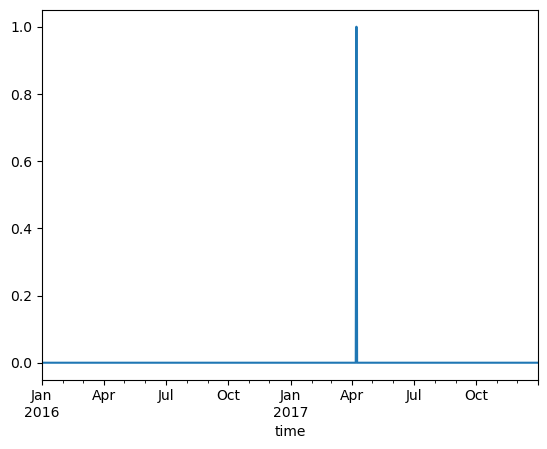

In [104]:
output = qaqc_unusual_gaps_precip(sub_df, 'pr', threshold=20, verbose=False)
output.astype("int").plot()

print(output.head(3))

In [117]:
#Check what dates were flagged 
#only worked when reset_index not used 
test_output = output[output] 
flagged_str = test_output.map({True: '33'})
print(flagged_str)

time
2017-04-08    33
Freq: D, Name: pr, dtype: object


In [118]:
sub_df['pr_eraqc'] = sub_df['time'].dt.date.map(flagged_str)

/tmp/ipykernel_2362/1648581132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['pr_eraqc'] = sub_df['time'].dt.date.map(flagged_str)


In [119]:
sub_df['pr_eraqc'].unique()

array([nan, '33'], dtype=object)

In [37]:
var = 'pr'

sub_df_2 = sub_df.copy()
sub_df_2[var].iloc[[325,1000]] = 500

/tmp/ipykernel_2362/1053285579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_2[var].iloc[[325,1000]] = 500


time
2016-01-13    True
2016-02-05    True
2017-04-08    True
Name: pr, dtype: bool

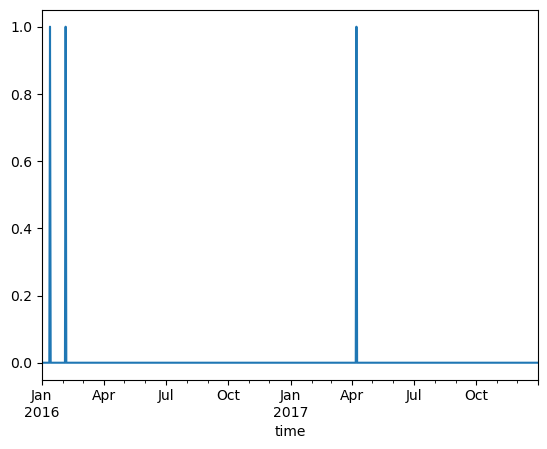

In [38]:
output = qaqc_unusual_gaps_precip(sub_df_2, 'pr', threshold=20, verbose=False)
output.astype("int").plot()

#Check what dates were flagged 
output[output]